In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import os
from pathlib import Path
from numpy.random import RandomState

_PRNG = RandomState(0)

In [2]:
_DATA_DIR = "./data"

names = []
dataset = []

for file_name in os.listdir(_DATA_DIR):
    if file_name.endswith(".csv"):
        full_file_path = _DATA_DIR + "/" + file_name
        print(full_file_path)
        dataset.append(pd.read_csv(full_file_path))
        names.append(file_name[10:16])

./data/LoanStats_2016Q1.csv


C:\Users\juszhan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (19) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


./data/LoanStats_2016Q2.csv
./data/LoanStats_2016Q3.csv


C:\Users\juszhan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (19,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


./data/LoanStats_2016Q4.csv
./data/LoanStats_2017Q1.csv


C:\Users\juszhan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (112) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


./data/LoanStats_2017Q2.csv
./data/LoanStats_2017Q3.csv
./data/LoanStats_2017Q4.csv
./data/LoanStats_2018Q1.csv


C:\Users\juszhan\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (123,124,125,128,129,130,133,139,140,141) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


./data/LoanStats_2018Q2.csv
./data/LoanStats_2018Q3.csv
./data/LoanStats_2018Q4.csv


In [3]:
_loan_status = ["Current", "Fully Paid", "In Grace Period", "Late (16-30 days)", "Late (31-120 days)", "Default", "Charged Off"]

loan_status = {x: [0] * len(dataset) for x in _loan_status}

for idx, df in enumerate(dataset):
    for k,v in df["loan_status"].value_counts().iteritems():
        loan_status[k][idx] = v

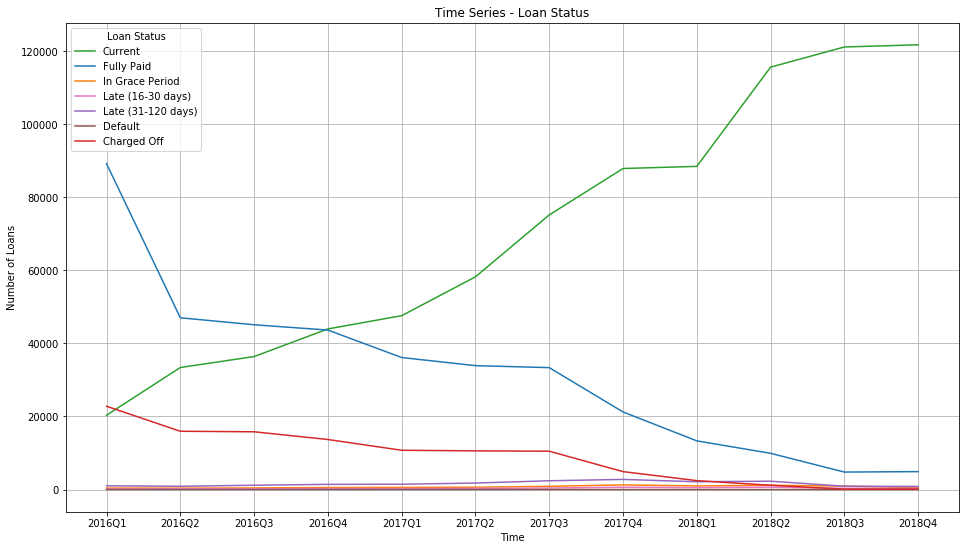

In [4]:
plt.figure(figsize=(16,9))

colors = {
    "Current" : "#2ca02c",
    "Fully Paid": "#1f77b4",
    "In Grace Period" : "#ff7f0e",
    "Late (16-30 days)" : "#e377c2",
    "Late (31-120 days)" : "#9467bd",
    "Default": "#8c564b",
    "Charged Off": "#d62728"    
}

x = list(range(len(dataset)))
for k, y in loan_status.items():
    plt.plot(x, y, label=k, color=colors[k])
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Status")
plt.title("Time Series - Loan Status")
plt.savefig("assets/Time Series - Loan Status.png", bbox_inches='tight')
plt.show()

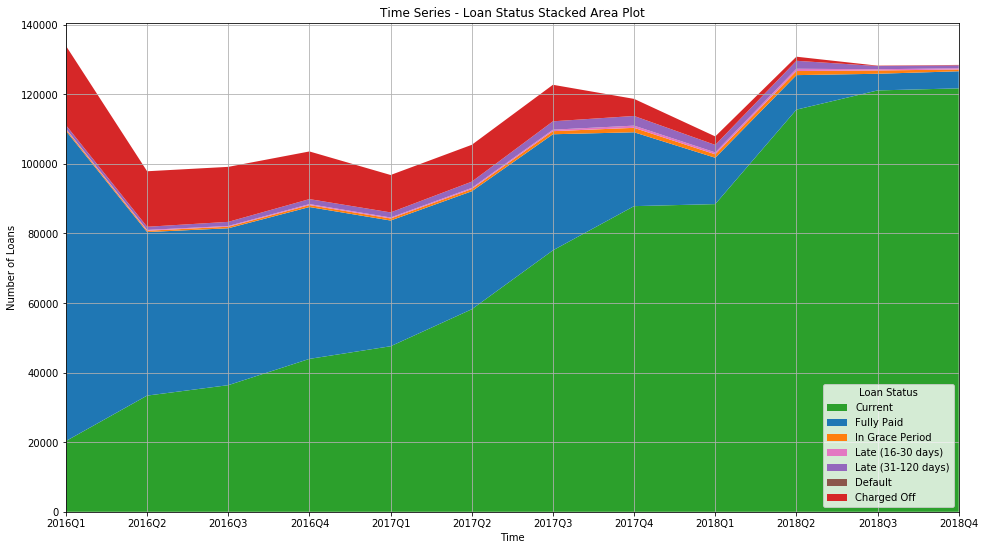

In [5]:
plt.figure(figsize=(16,9))

colors = {
    "Current" : "#2ca02c",
    "Fully Paid": "#1f77b4",
    "In Grace Period" : "#ff7f0e",
    "Late (16-30 days)" : "#e377c2",
    "Late (31-120 days)" : "#9467bd",
    "Default": "#8c564b",
    "Charged Off": "#d62728"    
}

x = list(range(len(dataset)))
plt.stackplot(x, *loan_status.values(), baseline="zero", labels=_loan_status, colors=colors.values())
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.xlim(left=0, right=len(dataset) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Status", loc=4)
plt.title("Time Series - Loan Status Stacked Area Plot")
plt.savefig("assets/Time Series - Loan Status Stacked Area Plot.png", bbox_inches='tight')
plt.show()

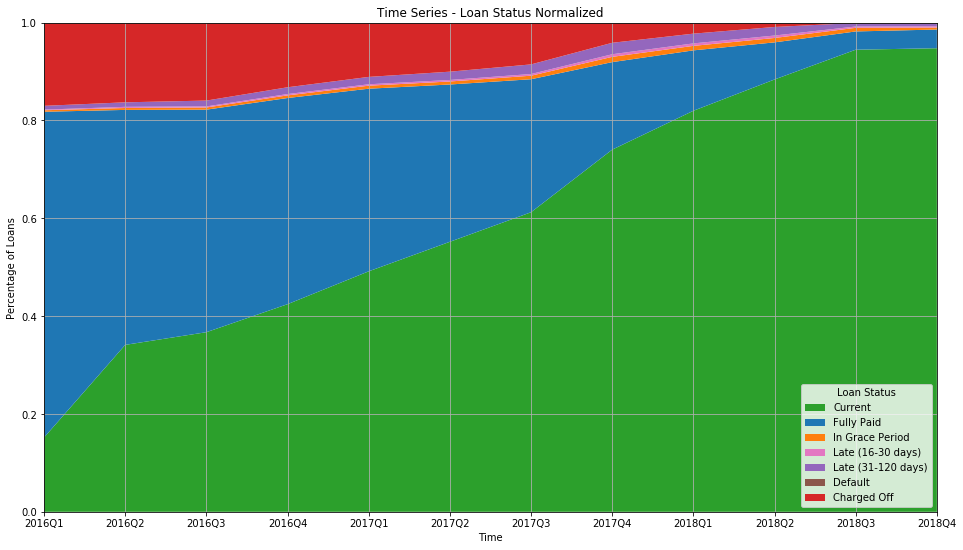

In [6]:
# Normalize loan_status
loan_status_normalized = {k: [loan_status_count / total for loan_status_count, total in zip(v, [len(df) for df in dataset])] for k,v in loan_status.items()}

plt.figure(figsize=(16,9))

colors = {
    "Current" : "#2ca02c",
    "Fully Paid": "#1f77b4",
    "In Grace Period" : "#ff7f0e",
    "Late (16-30 days)" : "#e377c2",
    "Late (31-120 days)" : "#9467bd",
    "Default": "#8c564b",
    "Charged Off": "#d62728"    
}

x = list(range(len(dataset)))
plt.stackplot(x, *loan_status_normalized.values(), baseline="zero", labels=_loan_status, colors=colors.values())
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.xlim(left=0, right=len(dataset) - 1)
plt.ylim(bottom=0, top=1.0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Percentage of Loans")
plt.legend(title="Loan Status", loc=4)
plt.title("Time Series - Loan Status Normalized")
plt.savefig("assets/Time Series - Loan Status Normalized.png", bbox_inches='tight')
plt.show()

In [7]:
_loan_status_grouped = ["Current", "Fully Paid", "Late", "Default/Charged Off"]
loan_status_grouped = {
    "Current": loan_status["Current"],
    "Fully Paid": loan_status["Fully Paid"],
    "Late": [sum([in_grace_period, late16, late30]) for in_grace_period, late16, late30 in zip(loan_status["In Grace Period"], loan_status["Late (16-30 days)"], loan_status["Late (31-120 days)"])],
    "Default/Charged Off": [sum([default, charged_off]) for default, charged_off in zip(loan_status["Default"], loan_status["Charged Off"])]
}

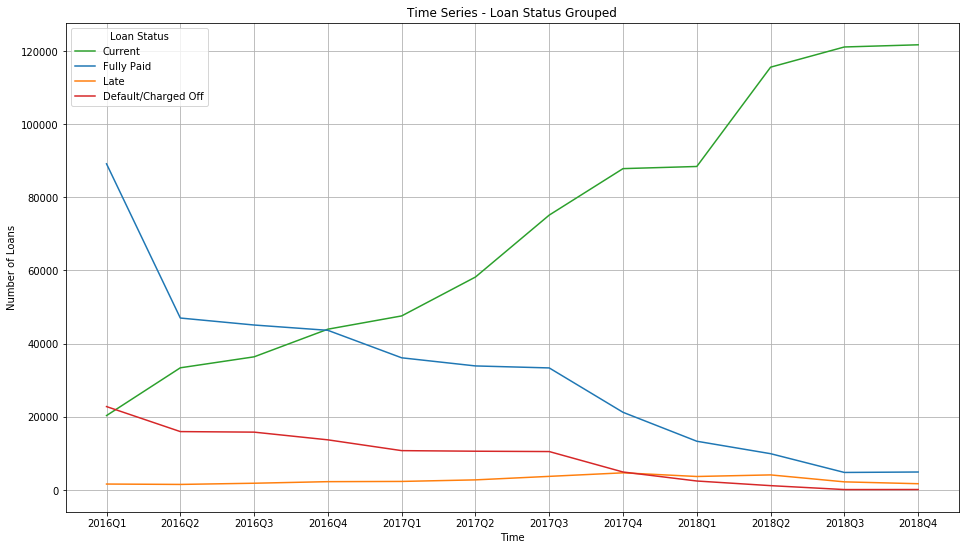

In [8]:
plt.figure(figsize=(16,9))

colors = {
    "Current" : "#2ca02c",
    "Fully Paid": "#1f77b4",
    "Late" : "#ff7f0e",
    "Default/Charged Off": "#d62728"    
}

x = list(range(len(dataset)))
for k, y in loan_status_grouped.items():
    plt.plot(x, y, label=k, color=colors[k])
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Status")
plt.title("Time Series - Loan Status Grouped")
plt.savefig("assets/Time Series - Loan Status Grouped.png", bbox_inches='tight')
plt.show()

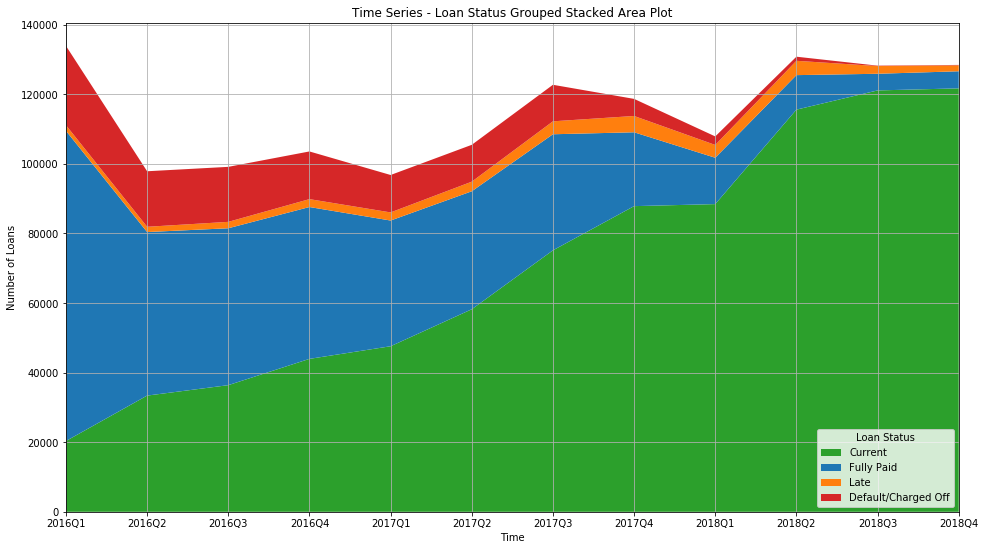

In [9]:
plt.figure(figsize=(16,9))

colors = {
    "Current" : "#2ca02c",
    "Fully Paid": "#1f77b4",
    "Late" : "#ff7f0e",
    "Default/Charged Off": "#d62728"    
}

x = list(range(len(dataset)))
plt.stackplot(x, *loan_status_grouped.values(), baseline="zero", labels=_loan_status_grouped, colors=colors.values())
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.xlim(left=0, right=len(dataset) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Status", loc=4)
plt.title("Time Series - Loan Status Grouped Stacked Area Plot")
plt.savefig("assets/Time Series - Loan Status Grouped Stacked Area Plot.png", bbox_inches='tight')
plt.show()

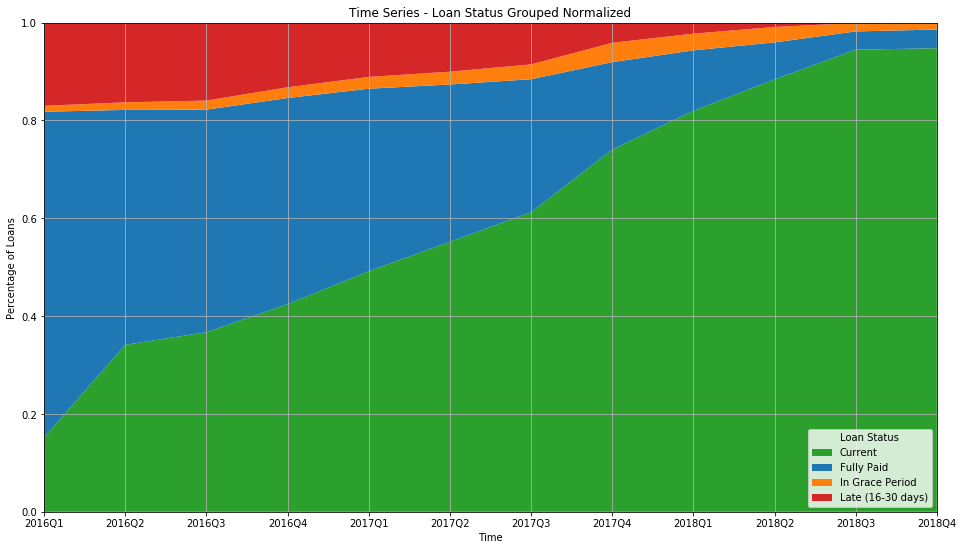

In [10]:
# Normalize grouped loan_status
loan_status_grouped_normalized = {k: [loan_status_grouped_count / total for loan_status_grouped_count, total in zip(v, [len(df) for df in dataset])] for k,v in loan_status_grouped.items()}

plt.figure(figsize=(16,9))

colors = {
    "Current" : "#2ca02c",
    "Fully Paid": "#1f77b4",
    "Late" : "#ff7f0e",
    "Default/Charged Off": "#d62728"    
}

x = list(range(len(dataset)))
plt.stackplot(x, *loan_status_grouped_normalized.values(), baseline="zero", labels=_loan_status, colors=colors.values())
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.xlim(left=0, right=len(dataset) - 1)
plt.ylim(bottom=0, top=1.0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Percentage of Loans")
plt.legend(title="Loan Status", loc=4)
plt.title("Time Series - Loan Status Grouped Normalized")
plt.savefig("assets/Time Series - Loan Status Grouped Normalized.png", bbox_inches='tight')
plt.show()

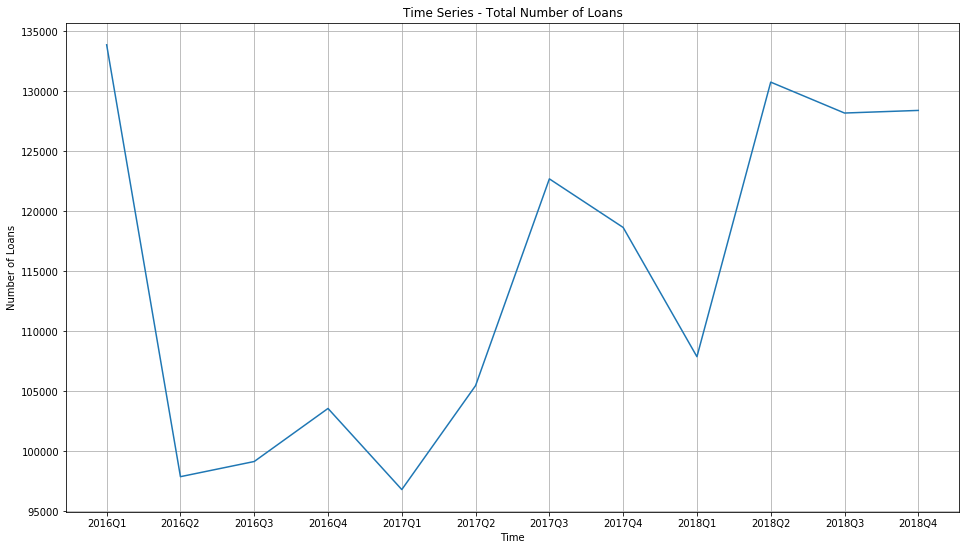

In [11]:
plt.figure(figsize=(16,9))

colors = {
    "Source Verified" : "#2ca02c",
    "Verified" : "#ff7f0e",
    "Not Verified" : "#d62728",
    "Total Loans" : "#1f77b4"
}

x = list(range(len(dataset)))
plt.plot(x, [len(df) for df in dataset], color=colors["Total Loans"])
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.title("Time Series - Total Number of Loans")
plt.savefig("assets/Time Series - Total Number of Loans.png", bbox_inches='tight')
plt.show()

In [12]:
_verification_status = ["Source Verified", "Verified", "Not Verified"]

verification_status = {k:[] for k in dataset[0]["verification_status"].unique()}

for df in dataset:
    for k,v in df[df["loan_status"] == "Current"]["verification_status"].value_counts().iteritems():
        verification_status[k].append(v)

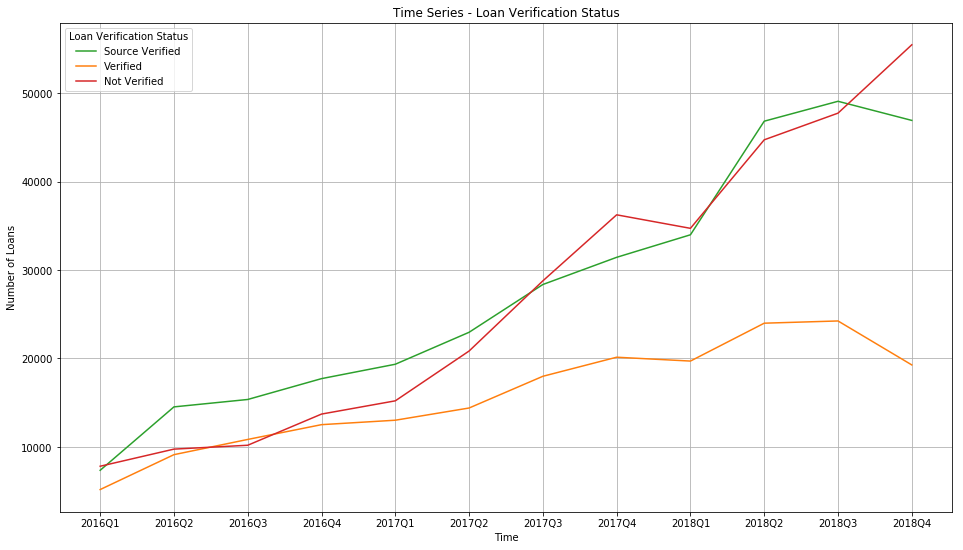

In [13]:
plt.figure(figsize=(16,9))

colors = {
    "Source Verified" : "#2ca02c",
    "Verified" : "#ff7f0e",
    "Not Verified" : "#d62728",
    "Total Loans" : "#1f77b4"
}

x = list(range(len(dataset)))
for k, y in verification_status.items():
    plt.plot(x, y, label=k, color=colors[k])
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Verification Status")
plt.title("Time Series - Loan Verification Status")
plt.savefig("assets/Time Series - Loan Verification Status.png", bbox_inches='tight')
plt.show()

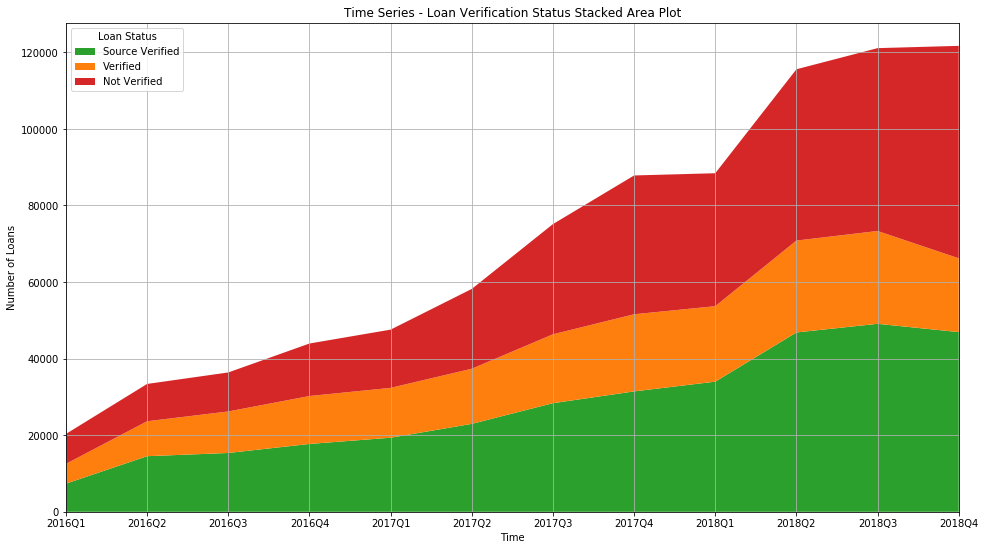

In [14]:
plt.figure(figsize=(16,9))

colors = {
    "Source Verified" : "#2ca02c",
    "Verified" : "#ff7f0e",
    "Not Verified" : "#d62728",
    "Total Loans" : "#1f77b4"
}

x = list(range(len(dataset)))
plt.stackplot(x, *verification_status.values(), baseline="zero", labels=_verification_status, colors=colors.values())
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.xlim(left=0, right=len(dataset) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Status", loc=2)
plt.title("Time Series - Loan Verification Status Stacked Area Plot")
plt.savefig("assets/Time Series - Loan Verification Status Stacked Area Plot.png", bbox_inches='tight')
plt.show()

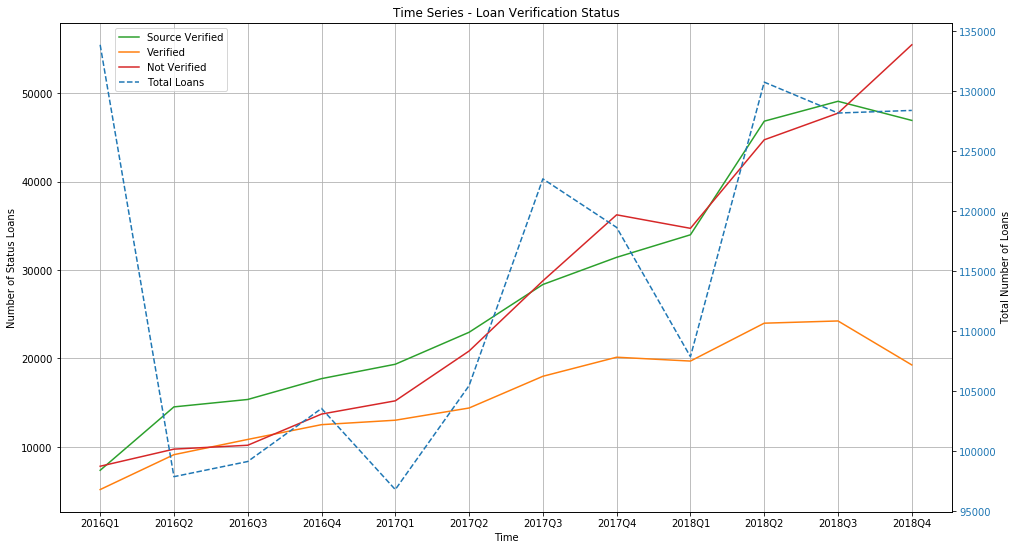

In [15]:
x = list(range(len(dataset)))

fig, ax = plt.subplots(figsize=(16,9))

lns = None

colors = {
    "Source Verified" : "#2ca02c",
    "Verified" : "#ff7f0e",
    "Not Verified" : "#d62728",
    "Total Loans" : "#1f77b4"
}
for k, y in verification_status.items():
    if lns is None:
        lns = ax.plot(x, y, label=k, color=colors[k])
        continue
    lns += ax.plot(x, y, label=k, color=colors[k])
    
ax_right = ax.twinx()
lns += ax_right.plot(x, [len(df) for df in dataset], label="Total Loans", color=colors["Total Loans"], linestyle="--")

plt.xticks(ticks=list(range(len(names))), labels=names)
ax.grid(True)
ax.set_xlabel("Time")
ax.set_ylabel("Number of Status Loans")
# ax.legend(lns, [l.get_label() for l in lns], loc=(.062, .889))
ax.legend(lns, [l.get_label() for l in lns], loc=(.062, .86))

ax_right.set_ylabel("Total Number of Loans")
ax_right.tick_params(axis='y', labelcolor=colors["Total Loans"])
# ax_right.legend(loc=(.83, .95))

plt.title("Time Series - Loan Verification Status")
plt.savefig("assets/Time Series - Loan Verification Status2.png", bbox_inches='tight')
plt.show()

In [16]:
loan_by_grade = {grade:[] for grade in list("ABCDEFG")}

for df in dataset:
    for k,v in df[df["loan_status"] == "Current"]["grade"].value_counts().iteritems():
        loan_by_grade[k].append(v)

In [17]:
sorted_grade = np.argsort(list(loan_by_grade.keys()))

grade = np.array(list(loan_by_grade.keys()))
grade_count = np.array(list(loan_by_grade.values()))

grade_count[sorted_grade]

array([[ 2708,  7940,  4535,  6241,  8137, 10802, 13908, 19741, 23015,
        30186, 36089, 36639],
       [ 5479, 10791, 12841, 14623, 15026, 18379, 23648, 28312, 27346,
        34359, 33089, 34139],
       [ 6494,  9138, 12192, 15051, 16947, 20530, 25892, 23926, 23349,
        31241, 29619, 29323],
       [ 2959,  3496,  4664,  5859,  4990,  5702,  7933, 12109, 11653,
        15489, 16589, 15823],
       [ 1926,  1456,  1485,  1675,  1844,  1984,  2568,  2860,  2552,
         3444,  4441,  5352],
       [  631,   444,   560,   385,   511,   580,   595,   659,   425,
          705,  1029,   321],
       [  139,   126,   112,   111,   117,   224,   587,   224,    76,
          137,   226,    79]])

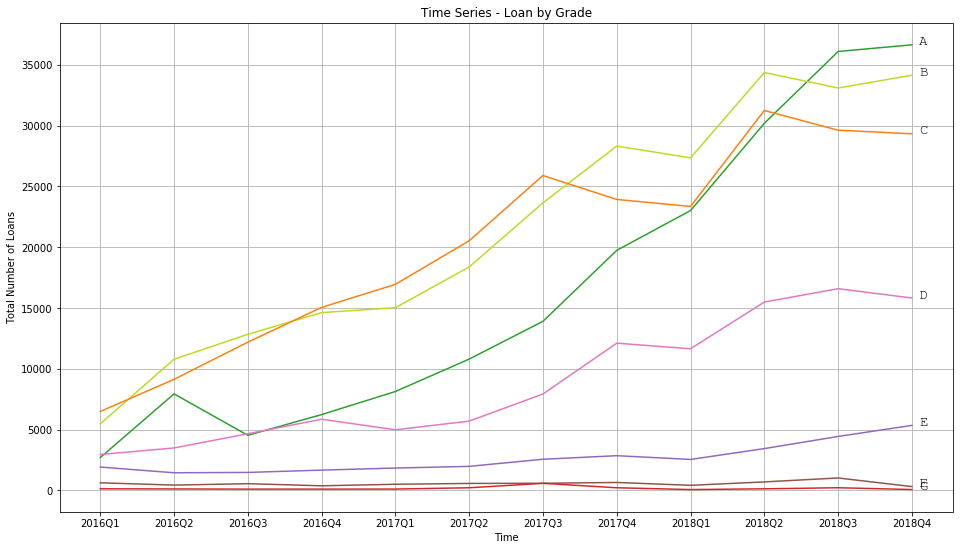

In [18]:
plt.figure(figsize=(16,9))

x = list(range(len(dataset)))
colors = ["#2ca02c", "#bcdb22", "#ff7f0e", "#e377c2", "#9467bd", "#8c564b", "#d62728"]
for y, color, label in zip(grade_count[sorted_grade], colors, list("ABCDEFG")):
    plt.plot(x, y, label=label, color=color)
    plt.annotate(label, xy=(x[-1] + 0.1, y[-1]), fontname="Courier New", fontsize=14)
plt.xticks(ticks=list(range(len(names))), labels=names)

plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Total Number of Loans")
# plt.legend(loc=2)
plt.title("Time Series - Loan by Grade")
plt.savefig("assets/Time Series - Loan by Grade.png", bbox_inches='tight')
plt.show()

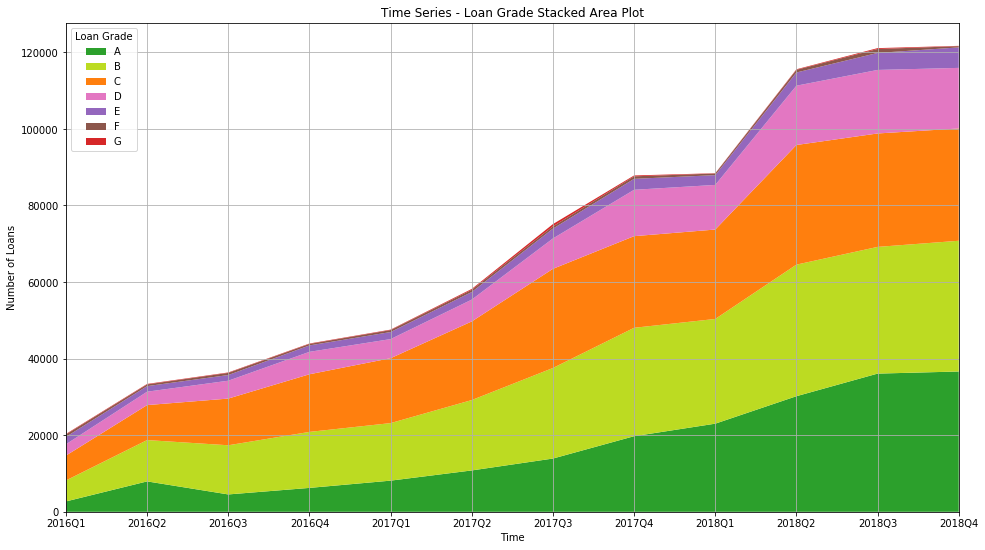

In [19]:
plt.figure(figsize=(16,9))

colors = ["#2ca02c", "#bcdb22", "#ff7f0e", "#e377c2", "#9467bd", "#8c564b", "#d62728"]

x = list(range(len(dataset)))
plt.stackplot(x, *grade_count[sorted_grade], baseline="zero", labels=list("ABCDEFG"), colors=colors)
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.xlim(left=0, right=len(dataset) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Grade", loc=2)
plt.title("Time Series - Loan Grade Stacked Area Plot")
plt.savefig("assets/Time Series - Loan Grade Stacked Area Plot.png", bbox_inches='tight')
plt.show()

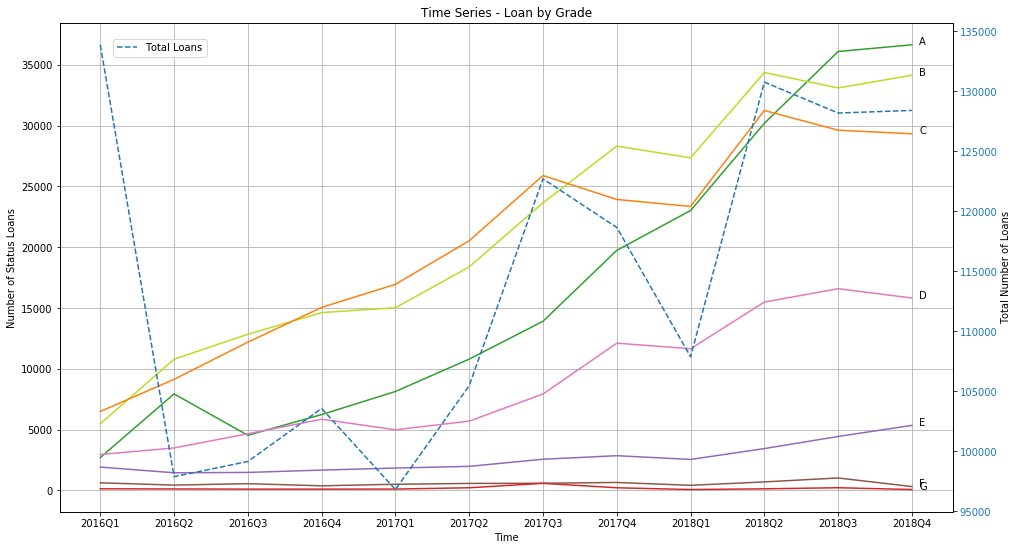

In [20]:
x = list(range(len(dataset)))

fig, ax = plt.subplots(figsize=(16,9))

lns = None

for y, color, label in zip(grade_count[sorted_grade], colors, list("ABCDEFG")):
    if lns is None:
        lns = ax.plot(x, y, label=label, color=color)
    else:
        lns += ax.plot(x, y, label=label, color=color)
    ax.annotate(label, xy=(x[-1] + 0.1, y[-1]))
    
ax_right = ax.twinx()
lns += ax_right.plot(x, [len(df) for df in dataset], label="Total Loans", color="#1f77b4", linestyle="--")

plt.xticks(ticks=list(range(len(names))), labels=names)
ax.grid(True)
ax.set_xlabel("Time")
ax.set_ylabel("Number of Status Loans")
# ax.legend(lns, [l.get_label() for l in lns], loc=(.062, .86))

ax_right.set_ylabel("Total Number of Loans")
ax_right.tick_params(axis='y', labelcolor="#1f77b4")
ax_right.legend(loc=(.06, .93))

plt.title("Time Series - Loan by Grade")
plt.savefig("assets/Time Series - Loan by Grade2.png", bbox_inches='tight')
plt.show()

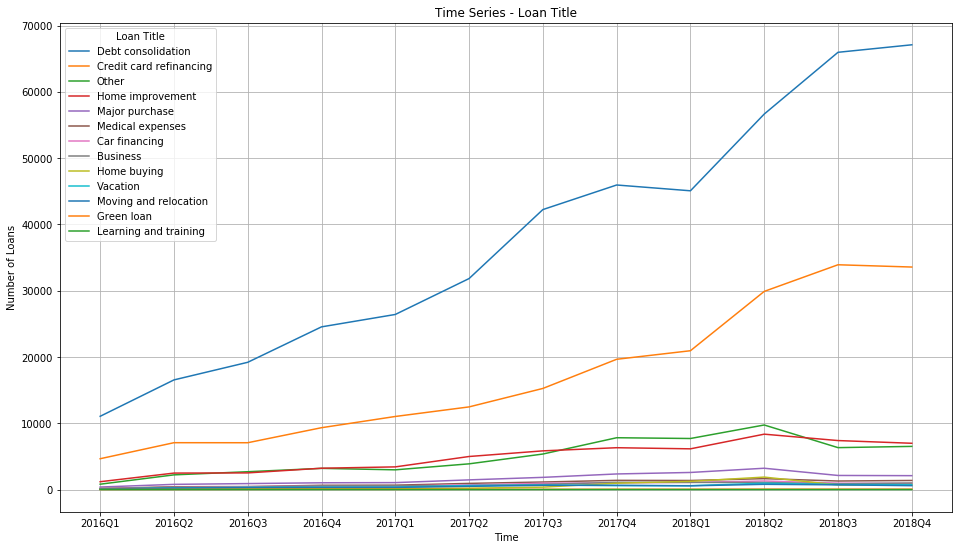

In [21]:
_titles = set()

for df in dataset:
    _titles = _titles.union(set(df[df["loan_status"] == "Current"]["title"].value_counts().keys()))

title = {x: [0] * len(dataset) for x in _titles}
for idx, df in enumerate(dataset):
    for k, v in df[df["loan_status"] == "Current"]["title"].value_counts().iteritems():
        title[k][idx] += v

from statistics import mean

ordered_title = [(mean(v), k) for k, v in title.items()]
ordered_title.sort(reverse=True)
        
plt.figure(figsize=(16,9))


x = list(range(len(dataset)))
for _, k in ordered_title:
    y = title[k]
    plt.plot(x, y, label=k)
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Title")
plt.title("Time Series - Loan Title")
plt.savefig("assets/Time Series - Loan Title.png", bbox_inches='tight')
plt.show()

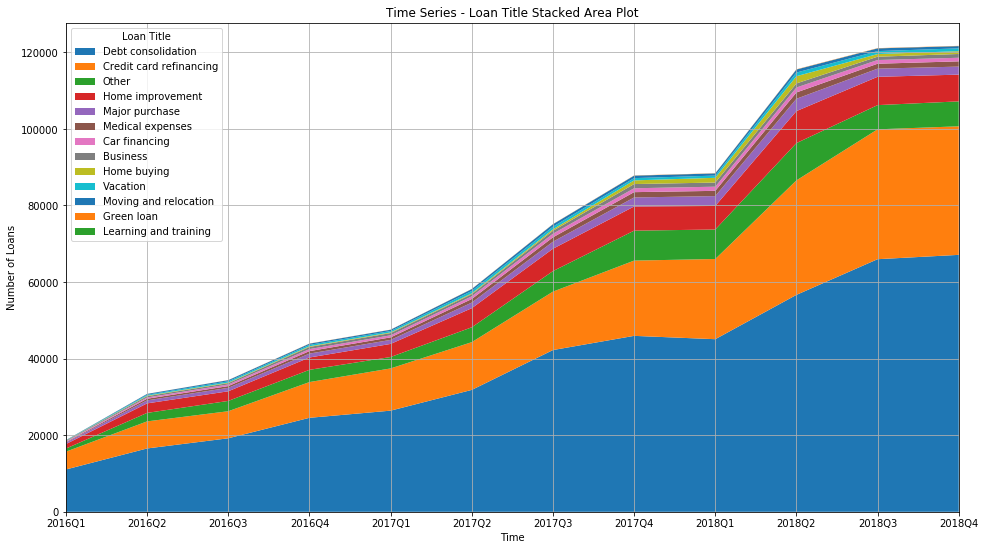

In [22]:
plt.figure(figsize=(16,9))

x = list(range(len(dataset)))
plt.stackplot(x, *[title[k] for _, k in ordered_title], baseline="zero", labels=[k for _, k in ordered_title])
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.xlim(left=0, right=len(dataset) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Title", loc=2)
plt.title("Time Series - Loan Title Stacked Area Plot")
plt.savefig("assets/Time Series - Loan Title Stacked Area Plot.png", bbox_inches='tight')
plt.show()

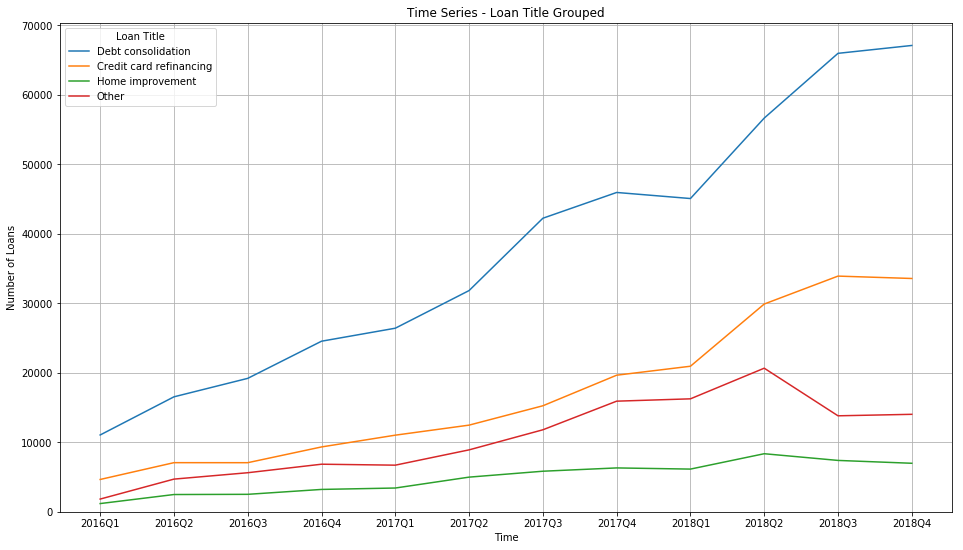

In [23]:
_titles = ["Debt consolidation", "Credit card refinancing", "Home improvement", "Other"]

title = {x: [0] * len(dataset) for x in _titles}

for idx, df in enumerate(dataset):
    for k,v in df[df["loan_status"] == "Current"]["title"].value_counts().iteritems():
        if k not in title:
            title["Other"][idx] += v
            continue
        title[k][idx] += v

plt.figure(figsize=(16,9))


x = list(range(len(dataset)))
for k, y in title.items():
    plt.plot(x, y, label=k)
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Title")
plt.title("Time Series - Loan Title Grouped")
plt.savefig("assets/Time Series - Loan Title Grouped.png", bbox_inches='tight')
plt.show()

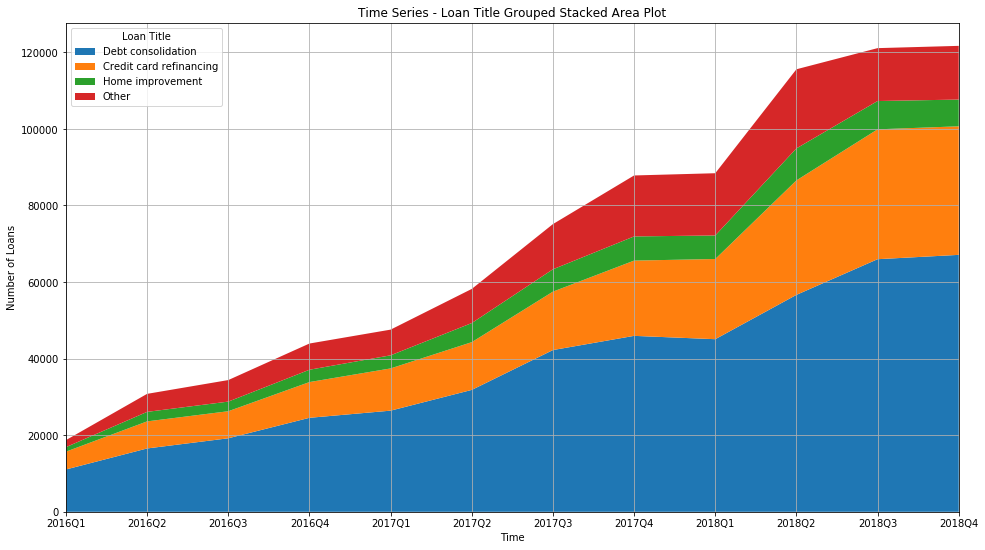

In [24]:
plt.figure(figsize=(16,9))

x = list(range(len(dataset)))
plt.stackplot(x, *title.values(), baseline="zero", labels=title.keys())
plt.xticks(ticks=list(range(len(names))), labels=names)
plt.xlim(left=0, right=len(dataset) - 1)
plt.ylim(bottom=0)
plt.grid(True)
plt.xlabel("Time")
plt.ylabel("Number of Loans")
plt.legend(title="Loan Title", loc=2)
plt.title("Time Series - Loan Title Grouped Stacked Area Plot")
plt.savefig("assets/Time Series - Loan Title Grouped Stacked Area Plot.png", bbox_inches='tight')
plt.show()